# Final Alignment
Ocassionaly, astronomy.net fails to solve! This can happen for  a number of reasons and is not consistent :( 

When this happens, we need to manually align any images that failed to get sky coordinates. I prefer to make the mosaic (using mosaic.py) with the images that astronet could solve for. Then, we need to find a bright source that is in both the mosaic and the image that is missing coordinates. We use this source to align the un-solved image and apply WCS to it :) The coordinates should be in physical or image units (in all the examples that I have done, they are identical).

In [23]:
# Imports!
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import skimage.registration as skf
import astroalign as aa

In [96]:
# Load the image and the WCS
mosaic_hdu = fits.open('/media/carterrhea/carterrhea/OMM/M101_original.fits')[0]  # load mosaic with WCS
image_none = fits.open('/media/carterrhea/carterrhea/OMM/stacked_5.fits')[0]  # Load image missing WCS
wcs = WCS(mosaic_hdu.header)

# Source coordinates in mosaic and in non-solved image
src_mos = [1755, 1295]  # mosaic coordinates  -- this is just an example
src_non = [906, 511]  # non-solved coordinates  -- this is just an example
# We now need to calculate the shift from the center of the non-solved image (it is 1025x1024)
# This assumes only a translation. If there is rotation, this becomes more involved and has thus not yet been implemented.
# A description of how to go about doing this can be found here http://nghiaho.com/?page_id=671
shift_ = [0,0]
if src_non[0] > 512:
    shift_[0] = src_non[0]-512
else:
    shift_[0] = 512-src_non[0]
if src_non[1] > 512:
    shift_[1] = src_non[1]-512
else:
    shift_[1] = 512-src_non[1]
print(shift_)
# Now calculate the final cutout position in the mosaic
final_ = [val1-val2 for val1,val2 in zip(src_mos, shift_)]
print(final_)
# Make the cutout, including the WCS
cutout = Cutout2D(mosaic_hdu.data, position=final_, size=(1025,1024), wcs=wcs)
# Update the FITS header with the cutout WCS
image_none.header.update(cutout.wcs.to_header())
# Write the cutout to a new FITS file
cutout_filename = '/media/carterrhea/carterrhea/OMM/stacked_correct_5.fits'
image_none.writeto(cutout_filename, overwrite=True)

[394, 1]
[1361, 1294]


## Using astrolign to solve for the rotation as well

UNDER DEVELOPMENT!

In [103]:
# We have to give it three points
src_mos = np.array([(1755, 1295), (1834, 1303), (1723, 1211.5)])  # mosaic coordinates  -- this is just an example
src_non = np.array([(906, 511), (978, 513), (918.2, 422.5)])
tform = aa.estimate_transform('similarity', np.array(src_non), np.array(src_mos))

In [104]:
print(src_mos[0])
print(tform.translation)

[1755. 1295.]
[ 581.14545317 1035.63779738]


In [105]:
t_form_final = tform.translation+src_non[0]

In [106]:
final_ = [val1-val2 for val1,val2 in zip(src_mos[0], t_form_final)]
print(final_)

[267.85454683265266, -251.63779737866457]


In [107]:
# Now apply the transform
registered_image = aa.apply_transform(tform, np.array(image_none.data).byteswap().newbyteorder(), np.array(mosaic_hdu.data).byteswap().newbyteorder())

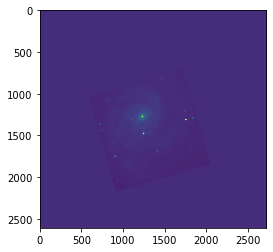

In [108]:
plt.imshow(registered_image[0], vmin=300, vmax=400)

In [109]:
# Now that we have the transformed image without WCS, we can update the header information
cutout = Cutout2D(mosaic_hdu.data, position=final_, size=(1025,1024), wcs=wcs)
# Update the FITS header with the cutout WCS
# Write the cutout to a new FITS file
hdu = fits.PrimaryHDU(header=cutout.wcs.to_header(), data=registered_image[0])
hdul = fits.HDUList([hdu])
hdul.writeto('/media/carterrhea/carterrhea/OMM/solved.fits', overwrite=True)